# Making an image of the Mandelbrot set using `htcondor-dags`

# The shape of the workflow

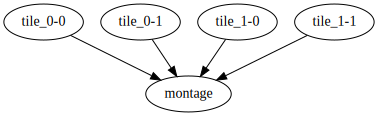

In [1]:
from graphviz import Digraph
import itertools

num_tiles_per_side = 2

dot = Digraph()

dot.node('montage')
for x, y in itertools.product(range(num_tiles_per_side), repeat = 2):
    n = f'tile_{x}-{y}'
    dot.node(n)
    dot.edge(n, 'montage')

dot

## Running `goatbrot` locally

`goatbrot` options:
- `-i 1000` The number of iterations.
- `-o test.ppm` The name of the output file to generate.
- `-c 0,0` The center point of the image region.
- `-w 3` The width of the image region.
- `-s 1000,1000` The pixel dimensions of the final image.

In [2]:
! ./goatbrot -i 1000 -c 0,0 -w 3 -s 1000,1000 -o test.ppm
! convert test.ppm test.png

Complex image:
            Center: 0 + 0i
             Width: 3
            Height: 3
        Upper Left: -1.5 + 1.5i
       Lower Right: 1.5 + -1.5i

Output image:
          Filename: test.ppm
     Width, Height: 1000, 1000
             Theme: beej
       Antialiased: no

Mandelbrot:
    Max Iterations: 1000
        Continuous: no

Goatbrot:
    Multithreading: not supported in this build

Completed: 100.0%                                                       


## Describing `goatbrot` as an HTCondor job

In [3]:
import htcondor

tile_description = htcondor.Submit(
    executable = 'goatbrot',
    arguments = '-i 1000 -c $(x),$(y) -w $(w) -s 500,500 -o tile_$(tile_x)-$(tile_y).ppm',
    log = 'mandelbrot.log',
    output = 'goatbrot.out.$(tile_x)_$(tile_y)',
    error = 'goatbrot.err.$(tile_x)_$(tile_y)',
    request_cpus = '1',
    request_memory = '128MB',
    request_disk = '1GB',
)

print(tile_description)

executable = goatbrot
arguments = -i 1000 -c $(x),$(y) -w $(w) -s 500,500 -o tile_$(tile_x)-$(tile_y).ppm
log = goatbrot.log
output = goatbrot.out.$(tile_x)_$(tile_y)
error = goatbrot.err.$(tile_x)_$(tile_y)
request_cpus = 1
request_memory = 128MB
request_disk = 1GB



In [4]:
def make_tile_vars(num_tiles_per_side, width = 3):
    width_per_tile = width / num_tiles_per_side
    
    centers = [
        width_per_tile * (n + 0.5 - (num_tiles_per_side / 2)) 
        for n in range(num_tiles_per_side)
    ]
    
    vars = []
    for (tile_y, y), (tile_x, x) in itertools.product(enumerate(centers), repeat = 2):
        var = dict(
            w = width_per_tile,
            x = x,
            y = -y,
            tile_x = str(tile_x).rjust(5, '0'),
            tile_y = str(tile_y).rjust(5, '0'),
        )
        
        vars.append(var)
        
    return vars

In [5]:
tile_vars = make_tile_vars(2)
for var in tile_vars:
    print(var)

{'w': 1.5, 'x': -0.75, 'y': 0.75, 'tile_x': '00000', 'tile_y': '00000'}
{'w': 1.5, 'x': 0.75, 'y': 0.75, 'tile_x': '00001', 'tile_y': '00000'}
{'w': 1.5, 'x': -0.75, 'y': -0.75, 'tile_x': '00000', 'tile_y': '00001'}
{'w': 1.5, 'x': 0.75, 'y': -0.75, 'tile_x': '00001', 'tile_y': '00001'}


## Describing montage as an HTCondor job

In [6]:
def make_montage_description(tile_vars):
    num_tiles_per_side = int(len(tile_vars) ** .5)
    
    input_files = [f'tile_{d["tile_x"]}-{d["tile_y"]}.ppm' for d in tile_vars]
    
    return htcondor.Submit(
        executable = '/usr/bin/montage',
        arguments = f'{" ".join(input_files)} -mode Concatenate -tile {num_tiles_per_side}x{num_tiles_per_side} mandelbrot.png',
        transfer_input_files = ', '.join(input_files),
        log = 'mandelbrot.log',
        output = 'montage.out',
        error = 'montage.err',
        request_cpus = '1',
        request_memory = '128MB',
        request_disk = '1GB',
    )

In [7]:
montage_description = make_montage_description(make_tile_vars(2))

print(montage_description)

executable = /usr/bin/montage
arguments = tile_00000-00000.ppm tile_00001-00000.ppm tile_00000-00001.ppm tile_00001-00001.ppm -mode Concatenate -tile 2x2 mandelbrot.png
transfer_input_files = tile_00000-00000.ppm, tile_00001-00000.ppm, tile_00000-00001.ppm, tile_00001-00001.ppm
log = montage.log
output = montage.out
error = montage.err
request_cpus = 1
request_memory = 128MB
request_disk = 1GB



## Describing the DAG using `htcondor-dags`

In [8]:
import htcondor_dags as dags

num_tiles_per_side = 2

tile_vars = make_tile_vars(num_tiles_per_side)

dag = dags.DAG()

tile_layer = dag.layer(
    name = 'tile',
    submit_description = tile_description,
    vars = tile_vars,
)

montage_layer = tile_layer.child(
    name = 'montage',
    submit_description = make_montage_description(tile_vars),
)

In [9]:
print(dag.describe())

Type     Name   # Nodes  # Children  Parents
Layer    tile      4         1              
Layer  montage     1         0       tile   


## Write the DAG to disk

In [10]:
from pathlib import Path
import shutil

dag_dir = Path('mandelbrot-dag').absolute()

shutil.rmtree(dag_dir)

dag_file = dag.write(dag_dir)
shutil.copy2('goatbrot', dag_dir)

print('DAG directory:', dag_dir)
print('DAG file:', dag_file)

DAG directory: /home/jovyan/htcondor-dags/examples/mandelbrot/mandelbrot-dag
DAG file: /home/jovyan/htcondor-dags/examples/mandelbrot/mandelbrot-dag/dagfile.dag


## Submit the DAG via the bindings

In [11]:
dag_submit = htcondor.Submit.from_dag(str(dag_file), {'force': 1})

print(dag_submit)

universe = scheduler
executable = /usr/bin/condor_dagman
getenv = True
output = /home/jovyan/htcondor-dags/examples/mandelbrot/mandelbrot-dag/dagfile.dag.lib.out
error = /home/jovyan/htcondor-dags/examples/mandelbrot/mandelbrot-dag/dagfile.dag.lib.err
log = /home/jovyan/htcondor-dags/examples/mandelbrot/mandelbrot-dag/dagfile.dag.dagman.log
remove_kill_sig = SIGUSR1
MY.OtherJobRemoveRequirements = "DAGManJobId =?= $(cluster)"
on_exit_remove = (ExitSignal =?= 11 || (ExitCode =!= UNDEFINED && ExitCode >=0 && ExitCode <= 2))
arguments = "-p 0 -f -l . -Lockfile /home/jovyan/htcondor-dags/examples/mandelbrot/mandelbrot-dag/dagfile.dag.lock -AutoRescue 1 -DoRescueFrom 0 -Dag /home/jovyan/htcondor-dags/examples/mandelbrot/mandelbrot-dag/dagfile.dag -Suppress_notification -CsdVersion $CondorVersion:' '8.9.4' 'Oct' '16' '2019' 'BuildID:' 'UW_Python_Wheel_Build' '$ -Force -Dagman /usr/bin/condor_dagman"
environment = _CONDOR_MAX_DAGMAN_LOG=0;_CONDOR_DAGMAN_LOG=/home/jovyan/htcondor-dags/examples

In [12]:
import os
os.chdir(dag_dir)

schedd = htcondor.Schedd()
with schedd.transaction() as txn:
    cluster_id = dag_submit.queue(txn)
    
print(cluster_id)

54


In [ ]:
! tail -f dagfile.dag.dagman.out

10/23/19 19:06:34 Warning: failed to get attribute DAGNodeName
10/23/19 19:06:34 DAGMAN_LOG_ON_NFS_IS_ERROR setting: False
10/23/19 19:06:34 Default node log file is: </home/jovyan/htcondor-dags/examples/mandelbrot/mandelbrot-dag/dagfile.dag.nodes.log>
10/23/19 19:06:34 Warning: the version ($CondorVersion: 8.9.4 Oct 16 2019 BuildID: UW_Python_Wheel_Build $) of this DAG's HTCondor submit file (created by condor_submit_dag) is newer than condor_dagman version ($CondorVersion: 8.9.3 Sep 17 2019 BuildID: Debian-8.9.3-1 PackageID: 8.9.3-1 Debian-8.9.3-1 $)
10/23/19 19:06:34 DAG Lockfile will be written to /home/jovyan/htcondor-dags/examples/mandelbrot/mandelbrot-dag/dagfile.dag.lock
10/23/19 19:06:34 DAG Input file is /home/jovyan/htcondor-dags/examples/mandelbrot/mandelbrot-dag/dagfile.dag
10/23/19 19:06:34 Parsing 1 dagfiles
10/23/19 19:06:34 Parsing /home/jovyan/htcondor-dags/examples/mandelbrot/mandelbrot-dag/dagfile.dag ...
10/23/19 19:06:34 Dag contains 5 total jobs
10/23/19 19:06:34